# Introduction 

**Conformal prediction** is a statistical framework that complements machine learning models by providing **valid measures of uncertainty** for individual predictions. Instead of outputting a single prediction (e.g., a class or a point estimate), a conformal predictor generates **prediction sets** (for classification) or **prediction intervals** (for regression) that are guaranteed to contain the true value with a **user-specified confidence level**, assuming the data are **exchangeable**.

---

## Overview

Imagine a model trained to classify images of clothing into three classes:
- `0 = T-shirt`
- `1 = Pants`
- `2 = Sneakers`.

Consider you have a **calibration set** of examples (separate from the training set), and now you're predicting a new image.

Step-by-step:

1. **Model output for a new image:**
   The model gives the following probabilities for each class:

   ```
   [T-shirt: 0.6, Pants: 0.3, Sneakers: 0.1]
   ```

2. **Nonconformity score for each possible label:**
   For each label `y`, compute the score: `1 - P(y)`

   * T-shirt: `1 - 0.6 = 0.4`
   * Pants: `1 - 0.3 = 0.7`
   * Sneakers: `1 - 0.1 = 0.9`

3. **Compare with calibration scores:**
   Suppose the 90th percentile of nonconformity scores in the calibration set is `0.75`.

4. **Build the prediction set:**
   Include all labels where the nonconformity score is ≤ 0.75:

   * T-shirt (0.4): ✅
   * Pants (0.7): ✅
   * Sneakers (0.9): ❌

   → **Prediction set = {T-shirt, Pants}**

Interpretation:

Instead of a single guess, the conformal predictor says:

> *"With 90% confidence, the true class is either T-shirt or Pants."*

This prediction set adjusts dynamically depending on model uncertainty and calibration data — providing **statistical guarantees** about coverage.

For regression, it might output:

> "The predicted price is \$300k, and I’m 90% confident the actual price lies between \$280k and \$320k."

---

# Nonconformity Scores

In **conformal prediction**, a **nonconformity score** quantifies **how "strange" or "atypical"** a new example is with respect to what the model has seen before. It answers:

> “How much does this prediction disagree with what I’ve observed during calibration?”

These scores are the foundation of conformal prediction: they allow us to compare test examples to past observations and decide whether to **include them in the prediction set**.

> Definition (**nonconformity score**). For a given input $x$ and a candidate label $y$, the **nonconformity score** $A(x, y)$ measures the degree to which $(x, y)$ **fails to conform** to the model's learned patterns. 

---

## How Are Nonconformity Scores Computed?

The choice of $A$ (the nonconformity function) depends on the **task** and the **model**.

### 📌 1. **Classification (with probabilities)**

For classifiers that output class probabilities (e.g., softmax or logistic regression), a common choice is:

$$
\boxed{
A(x, y) = 1 - \hat{P}(y \mid x)
}
$$

Where:

* $\hat{P}(y \mid x)$ is the model's predicted probability for class $y$.
* A lower probability means **higher nonconformity** (more "surprising").

As an example, consider a multi-class classifier with three classes. The first column in the table below shows the softmax probabilities produced by this classifier for two examples. The second and third columns show the true label and the corresponding nonconformity score. 

<center>

| Class Probabilities | True Label | Nonconformity Score |
| ------------------- | ---------- | ------------------- |
| \[0.6, 0.3, 0.1]    | 0          | $1 - 0.6 = 0.4$     |
| \[0.6, 0.3, 0.1]    | 2          | $1 - 0.1 = 0.9$     |

</center>

Notice that the second example is more non-conformal than the first one. This is related to how **nonconformity scores** reflect a model's **confidence (or lack thereof)** in its predictions. In both rows, the model outputs the **same predicted probabilities**:

* 60% for class 0
* 30% for class 1
* 10% for class 2

But the **true labels are different**:

* In the first case, the true label is **0**, which is the class the model is most confident in (60%).
* In the second case, the true label is **2**, which the model assigns only **10%** probability — its **least likely** class.

Interpretation:

* First row: $A = 1 - 0.6 = 0.4$ → the model was fairly confident in the correct class → **moderately conforming**.
* Second row: $A = 1 - 0.1 = 0.9$ → the model was very **unconfident** in the true label → **highly nonconforming**.

So the **second example is more nonconformal** because the model assigned the **lowest probability** to the true class, which means the prediction **deviated more** from what the model “expected.”

> [**Intuition**] The nonconformity score measures **how surprised the model is** to see that the true label is $y$. The more surprised, the higher the score.

---

### 📌 2. **Regression**

In regression, a natural nonconformity score is the **absolute error**:

$$
\boxed{
A(x, y) = |y - \hat{y}(x)|
}
$$

Where:

* $y$ is the true target value for example $x$.
* $\hat{y}(x)$ is the model’s predicted value for example $x$.

In this case, the larger the absolute error, the more nonconforming the point is.

---

### 📌 3. **General Definition (Custom Models)**

You can define nonconformity scores in any way that reflects how "unusual" a (prediction, label) pair is — for example:

* Distance to nearest neighbors
* Margin between predicted probabilities
* Output uncertainty from Bayesian models
* Ensemble disagreement

As long as the function $A(x, y)$ assigns **low scores to familiar predictions** and **high scores to unusual ones**, it can be used in conformal prediction.


## Steps to Apply Conformal Prediction

This section presents a structured summary of the **steps to apply conformal prediction**, applicable to both **classification** and **regression** tasks.

Before starting:

* Decide on the task: **classification** or **regression**.
* Choose or train a **base predictive model** (e.g., logistic regression, neural network, random forest).
* Define a **nonconformity score** $A(x, y)$ (e.g., $1 - \hat{P}(y \mid x)$, or $|y - \hat{y}|$).

### **1. Split the Data**

Partition your data into three sets:

* **Training set**: to train the base model.
* **Calibration set**: to compute nonconformity scores and set the threshold.
* **Test set**: to evaluate and apply conformal prediction.

This is called the **Inductive Conformal Prediction (ICP)** setup.

---

### **2. Train the Base Model**

Train your predictive model $\hat{f}$ using the training set.

---

### **3. Compute Nonconformity Scores on Calibration Set**

For each calibration point $(x_i, y_i)$:

* **Classification**:

  $$
  A(x_i, y_i) = 1 - \hat{P}(y_i \mid x_i)
  $$

* **Regression**:

  $$
  A(x_i, y_i) = |y_i - \hat{y}(x_i)|
  $$

Store all scores:

$$
s_1, s_2, \dots, s_n
$$

---

### **4. Compute the Threshold**

Given a desired **confidence level** $1 - \alpha$, compute the **quantile threshold** $q$ using the sorted calibration scores:

$$
q = \text{sorted\_scores}[\lceil (n + 1)(1 - \alpha) \rceil - 1]
$$

---

### **5. Apply to Test Samples**

For each test input $x$, compute a **prediction set**:

* **Classification**:
  Include all class labels $y$ such that:

  $$
  1 - \hat{P}(y \mid x) \leq q
  \quad \text{or} \quad
  \hat{P}(y \mid x) \geq 1 - q
  $$

* **Regression**:
  Construct a prediction **interval**:

  $$
  [\hat{y}(x) - q, \hat{y}(x) + q]
  $$

---

### **6. Evaluate Performance (Optional)**

On test data:

* Measure **empirical coverage**:

  $$
  \frac{\text{\# times } y_{\text{true}} \in \Gamma(x)}{\text{\# test samples}}
  $$
* Measure **average prediction set size** or **interval width**.
* Compare with your confidence level $1 - \alpha$.

---

## Summary Flowchart

```plaintext
 ┌──────────────┐
 │ Train Model  │ ←─ Training Set
 └──────────────┘
       ↓
 ┌────────────────────┐
 │ Compute Scores     │ ←─ Calibration Set
 │ A(x, y)            │
 └────────────────────┘
       ↓
 ┌────────────────────┐
 │ Compute Threshold q│ ←─ Using α
 └────────────────────┘
       ↓
 ┌────────────────────────────┐
 │ Predict + Apply Threshold  │ ←─ Test Set
 └────────────────────────────┘
       ↓
 ┌────────────────────────────┐
 │ Output: Prediction Sets    │
 │ or Prediction Intervals    │
 └────────────────────────────┘
```

# Example: Conformal Prediction for Regression

This section presents an example of implementing **conformal prediction for regression**. Key points in the code shown below are the following:

* Data is split the data into training, calibration, and test sets.
* After training, residuals are estimated on the **calibration set** (not on training set).
* The `90%` interval is derived using the `quantile` of calibration residuals.
* This is a **split conformal** method, fast and model-agnostic.

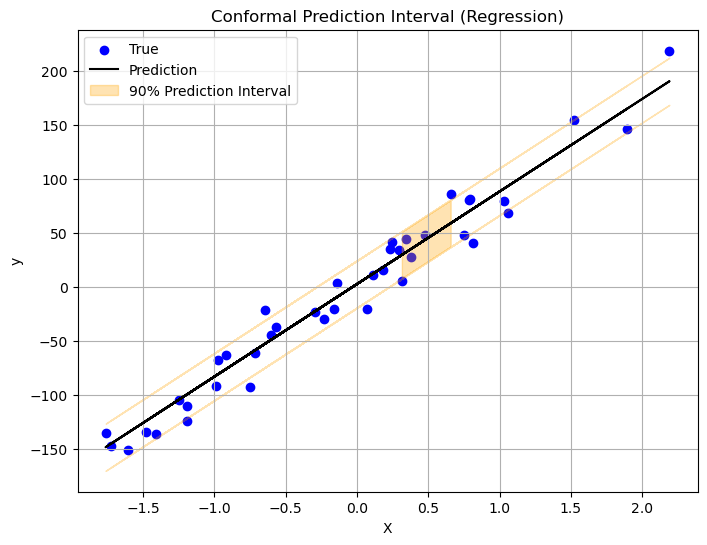

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# 1. Generate synthetic data
X, y = make_regression(n_samples=200, n_features=1, noise=15, random_state=42)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 2. Fit regression model
model = LinearRegression()
model.fit(X_train, y_train)

# 3. Predict and compute calibration residuals
y_calib_pred = model.predict(X_calib)
residuals = np.abs(y_calib - y_calib_pred)

# 4. Define quantile threshold for 90% prediction interval
alpha = 0.1
q = np.quantile(residuals, 1 - alpha)

# 5. Predict on test set with prediction intervals
y_test_pred = model.predict(X_test)
y_lower = y_test_pred - q
y_upper = y_test_pred + q

# 6. Plot results
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='blue', label='True')
plt.plot(X_test, y_test_pred, color='black', label='Prediction')
plt.fill_between(X_test.ravel(), y_lower, y_upper, color='orange', alpha=0.3, label='90% Prediction Interval')
plt.title("Conformal Prediction Interval (Regression)")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


# Example: Conformal Prediction for Classification

Below is an example of implementing **conformal prediction for classification**, using the **Inductive Conformal Prediction (ICP)**. ICP will output **prediction sets** — i.e., sets of class labels likely to contain the true label with high probability.

ICP is a variant of conformal prediction that provides valid prediction sets using a data-splitting strategy:

> It splits the dataset into a training set to fit the model and a calibration set to compute nonconformity scores and thresholds.

ICP is computationally efficient compared to full (transductive) conformal prediction, while still guaranteeing valid coverage under the assumption of exchangeability.

Key points of the code shown below:

* An imbalanced 3-class classification dataset is simulated
* **Nonconformity score:** $s_i = 1 - \hat{P}(\text{true class})$
* **Prediction set:** All classes where $1 - \hat{P}(y) \leq q_{1 - \alpha}$

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs

np.random.seed(42)

# Simulate a imbalanced dataset
n_classes = 3
# Make train and test data
X, y = make_blobs(n_samples=10000, n_features=2, centers=n_classes, cluster_std=3.75, random_state=42)

def imbalance_data(X, y, imbalance_ratio):
    """
    Create an imbalanced dataset by removing samples from the first class.
    """
    # Get the number of samples in the first class
    n_samples_class_0 = np.sum(y == 0)
    
    # Calculate the number of samples to remove
    n_samples_to_remove = int(n_samples_class_0 * imbalance_ratio)
    
    # Get the indices of the samples to remove
    indices_to_remove = np.where(y == 0)[0][:n_samples_to_remove]
    
    # Remove the samples from class 0
    X = np.delete(X, indices_to_remove, axis=0)
    y = np.delete(y, indices_to_remove, axis=0)
    
    return X, y

# Create an imbalanced dataset
X, y = imbalance_data(X, y, 0.7)

# Split data into train, calibration, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42)
X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print class distribution
print("Class distribution in training set:", np.bincount(y_train))
print("Class distribution in calibration set:", np.bincount(y_calib))
print("Class distribution in test set:", np.bincount(y_test))

Class distribution in training set: [ 498 1677 1658]
Class distribution in calibration set: [260 865 792]
Class distribution in test set: [243 791 883]


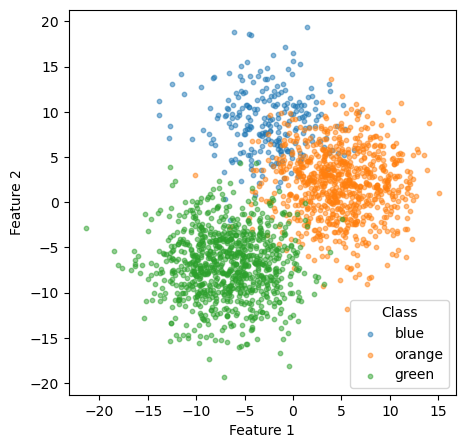

In [19]:
# Set class labels
class_labels = ['blue', 'orange', 'green']

# Plot the data
fig = plt.subplots(figsize=(5, 5))
ax = plt.subplot(111)
for i in range(n_classes):
    ax.scatter(X_test[y_test == i, 0], X_test[y_test == i, 1], label=class_labels[i], alpha=0.5, s=10)
legend = ax.legend()
legend.set_title("Class")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
plt.show()

In [20]:
# 2. Train classifier
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

# 6. Predict on test set
y_pred = clf.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:0.3f}")

# Test recall for each class
for i in range(n_classes):
    recall = np.mean(y_pred[y_test == i] == y_test[y_test == i])
    print(f"Recall for class {class_labels[i]}: {recall:0.3f}")

Accuracy: 0.941
Recall for class blue: 0.794
Recall for class orange: 0.944
Recall for class green: 0.978


We will now predict classification probabilities of the calibration set. This will be used to set a classification threshold for new data.

In [21]:
# 3. Get probability scores on calibration set
y_pred_proba = clf.predict_proba(X_calib)

y_pred_proba[:5]

array([[9.31649856e-03, 9.90458251e-01, 2.25250123e-04],
       [7.78793632e-01, 2.20844258e-01, 3.62109839e-04],
       [4.16422075e-05, 1.23564629e-03, 9.98722711e-01],
       [6.50267490e-03, 9.55530724e-01, 3.79666010e-02],
       [1.12177487e-03, 9.98720443e-01, 1.57782195e-04]])

## Compute the Nonconformity Scores

We will calculate **non-conformity scores** only based on looking at probabilities associated with the observed class. For each instance we will get the predicted probability for the class of that instance. The non-conformality score is 1-probability. The higher the score, the less that example conforms to that class in comparison to other classes.

In [33]:
# 4. Compute nonconformity scores: 1 - prob(correct class)
nonconformity_scores = 1 - np.array([y_pred_proba[i, y_calib[i]] for i in range(len(y_calib))])
# Print the first 5 nonconformity scores, which indicate how "surprising" each prediction is.
# The lower the score, the more confident the model is about its prediction.
nonconformity_scores[0:5]

array([0.00954175, 0.22120637, 0.00127729, 0.04446928, 0.00127956])

## Compute the Threshold

The percentile threshold in conformal prediction — often derived as a quantile of the nonconformity scores on a calibration set — serves a very specific and foundational purpose: it serves to decide which predictions are “safe enough” to be included based on past experience.

In [23]:
number_of_samples = len(X_calib)
alpha = 0.05
qlevel = (1 - alpha) * ((number_of_samples + 1) / number_of_samples)
threshold = np.percentile(nonconformity_scores, qlevel*100)
print(f'Threshold: {threshold}')

Threshold: 0.6910973506334739


In [24]:
# Sorted scores with correction
sorted_scores = np.sort(nonconformity_scores)
n_calib = len(sorted_scores)
k = int(np.ceil((n_calib + 1) * (1 - alpha)))
threshold = sorted_scores[min(k - 1, n_calib - 1)]  # clip index if needed

threshold

0.6925756323941066

## Visualizing the threshold (1)

The plot below shows the **distribution of nonconformity scores** (e.g., $1 - P(\text{true label})$) from a calibration set, along with a **red dashed line** marking the **finite-sample corrected threshold**. Any predicted class with a nonconformity score below this threshold would be included in the prediction set at the desired confidence level (50% in this case).

This visual shows how the threshold filters out low-confidence predictions and controls the prediction set size to achieve valid coverage. Let me know if you'd like to overlay example test scores or simulate how changing the confidence level affects the threshold.


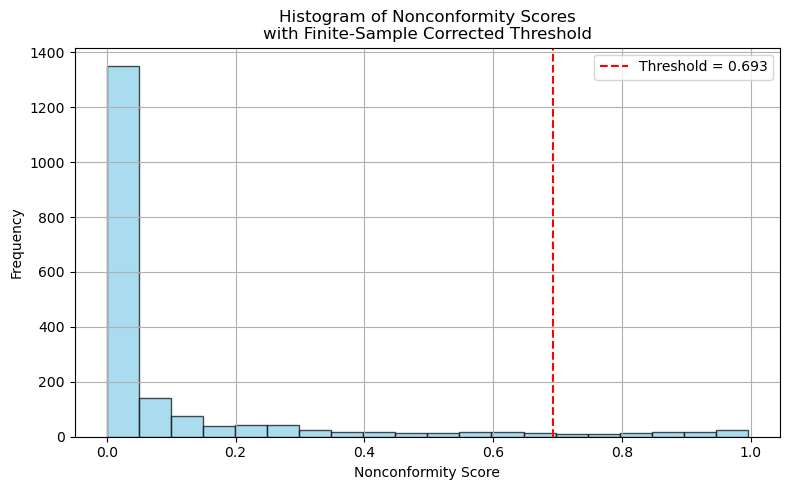

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated nonconformity scores from a calibration set
np.random.seed(42)

# Confidence level
n = len(nonconformity_scores)
sorted_scores = np.sort(nonconformity_scores)

# Finite-sample corrected threshold
k = int(np.ceil((n + 1) * (1 - alpha)))
threshold = sorted_scores[min(k - 1, n - 1)]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(nonconformity_scores, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.3f}')
plt.title('Histogram of Nonconformity Scores\nwith Finite-Sample Corrected Threshold')
plt.xlabel('Nonconformity Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Visualizing the threshold (2)

The plot below shows **sorted calibration instances** (by index) against their corresponding **nonconformity scores**. The red dashed line marks the **threshold** (finite-sample corrected), and the green dotted line marks the **position $k$** used to compute that threshold.

### Interpretation:

* Points **below the red line** have nonconformity scores low enough to be included in prediction sets.
* The point where the green line crosses the curve determines the cutoff to ensure the desired **coverage**.

This helps us visualize which calibration instances are deemed "typical" versus "atypical" by the model under the current confidence level.


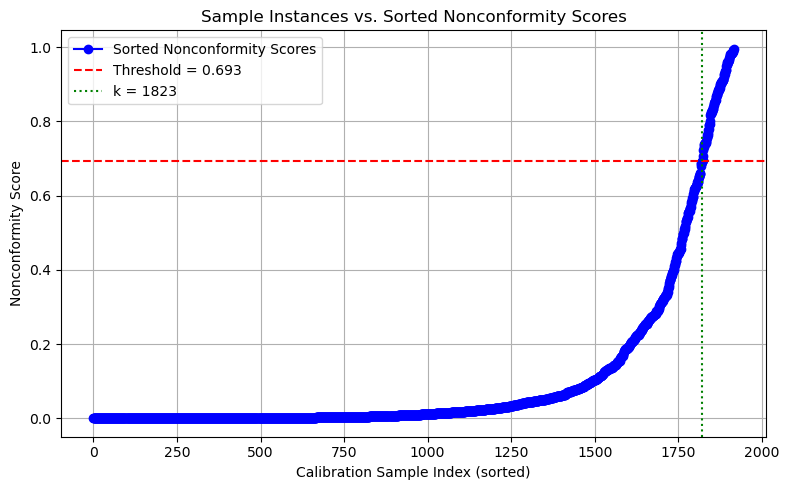

In [26]:
# Plot sample index vs nonconformity score
plt.figure(figsize=(8, 5))
plt.plot(range(n), sorted_scores, marker='o', linestyle='-', color='blue', label='Sorted Nonconformity Scores')
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.3f}')
plt.axvline(k - 1, color='green', linestyle=':', label=f'k = {k}')
plt.title('Sample Instances vs. Sorted Nonconformity Scores')
plt.xlabel('Calibration Sample Index (sorted)')
plt.ylabel('Nonconformity Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Visualizing the threshold (3)

In this plot:

Here's the revised plot showing the **nonconformity scores for 100 test examples** (orange Xs) against their sample index, along with the **threshold** (red dashed line).

### Interpretation:

* Points **below** the red line: these predictions would be included in the prediction set (they "conform").
* Points **above**: these would be excluded (they "don't conform" at the selected confidence level).

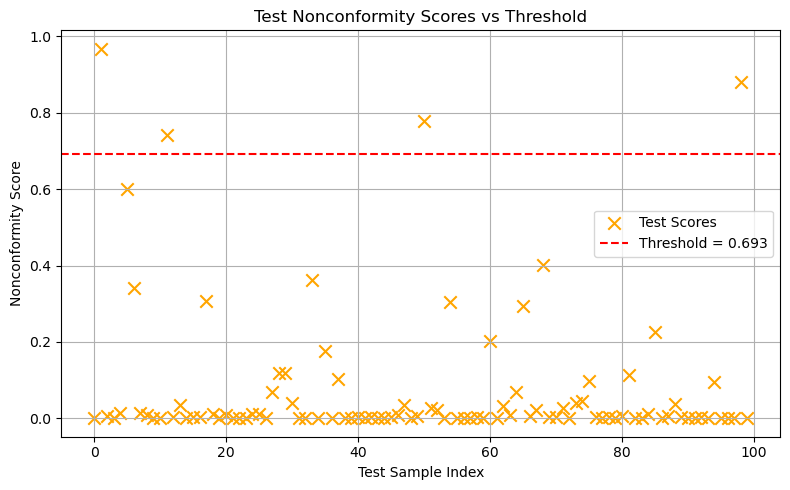

In [27]:
# Visualize nonconformity scores for 100 test samples
n_test = 100

test_scores = 1 - clf.predict_proba(X_test[:n_test])[
    np.arange(n_test), y_test[:n_test]]
# Ensure test scores are sorted for plotting

# Plot only test nonconformity scores with threshold line
plt.figure(figsize=(8, 5))
plt.scatter(np.arange(n_test), test_scores, color='orange', s=80, marker='x', label='Test Scores')
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.3f}')
plt.title('Test Nonconformity Scores vs Threshold')
plt.xlabel('Test Sample Index')
plt.ylabel('Nonconformity Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Visualizing the threshold (4)

A principled way to visually assess whether conformal prediction assumptions are holding is to plot the **Empirical Cumulative Distribution Functions (ECDFs)** for both calibration and test datasets. 

The plot below shows the *ECDFs* of the:

* **Calibration scores** (blue curve)
* **Test scores** (orange curve)

The **red dashed line** is the **threshold** computed from the calibration ECDF.

### Interpretation:

* If both curves are **close together**, it supports the assumption that calibration and test scores are drawn from the **same distribution** (i.e., exchangeability).
* If the **orange curve is consistently below the blue**, test scores are **more extreme**, and coverage might be lower than expected.
* If the **orange curve is above**, test scores are more "typical", and coverage might be overly conservative.

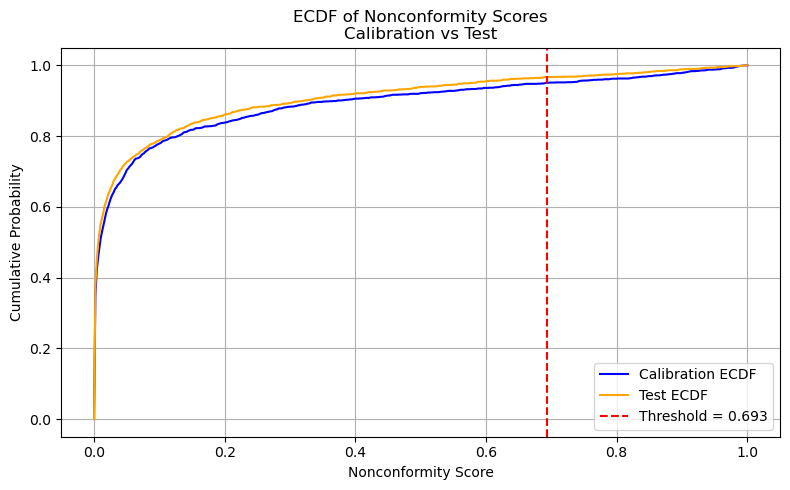

In [28]:
import statsmodels.api as sm

n_test = X_test.shape[0]
test_scores = 1 - clf.predict_proba(X_test[:n_test])[
    np.arange(n_test), y_test[:n_test]]

# Compute ECDFs
ecdf_calib = sm.distributions.ECDF(nonconformity_scores)
ecdf_test = sm.distributions.ECDF(test_scores)

x_vals = np.linspace(0, 1, 500)

# Plot ECDFs
plt.figure(figsize=(8, 5))
plt.plot(x_vals, ecdf_calib(x_vals), label='Calibration ECDF', color='blue')
plt.plot(x_vals, ecdf_test(x_vals), label='Test ECDF', color='orange')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.3f}')
plt.title('ECDF of Nonconformity Scores\nCalibration vs Test')
plt.xlabel('Nonconformity Score')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Apply to Test samples (Constructing the prediction sets)

In [29]:
prediction_sets = []

y_pred_test = clf.predict_proba(X_test)

for prob in y_pred_test:
    pred_set = [i for i in range(prob.shape[0]) if 1 - prob[i] <= threshold]
    prediction_sets.append(pred_set)
print(f"Prediction sets for first 10 test samples: {prediction_sets[:10]}")

Prediction sets for first 10 test samples: [[2], [1], [1], [2], [2], [1, 2], [0, 1], [1], [1], [2]]


In [30]:
prediction_sets = (1 - clf.predict_proba(X_test) <= threshold)
# Show first ten instances
prediction_sets[0:10]

array([[False, False,  True],
       [False,  True, False],
       [False,  True, False],
       [False, False,  True],
       [False, False,  True],
       [False,  True,  True],
       [ True,  True, False],
       [False,  True, False],
       [False,  True, False],
       [False, False,  True]])

## Visualizing the predition sets

This code provided in this section generates a **summary DataFrame** (`results_sets`) that helps you **evaluate and interpret the output of a conformal classifier**. Let’s walk through what each column represents and how to read it.

### Assumptions

* `clf` is a trained classifier (e.g., `LogisticRegression`).
* `X_test`, `y_test`: test features and true class indices.
* `class_labels`: list of class names or labels (e.g., `["setosa", "versicolor", "virginica"]`).
* `prediction_sets`: a list of boolean vectors, one per test instance, where each boolean vector indicates which classes are included in that test instance’s **conformal prediction set**.

### What the Code Produces

<center>

| Column                | Meaning                                                                                                                                  |
| --------------------- | ---------------------------------------------------------------------------------------------------------------------------------------- |
| **`observed`**        | The **true class label** for each test sample.                                                                                           |
| **`labels`**          | The **prediction set** for that test sample — i.e., the set of class labels that were included based on the conformal threshold.         |
| **`classifications`** | The **argmax (standard) prediction** from the classifier — i.e., what `clf.predict` would return without any uncertainty quantification. |

</center>

---

### How to Use the Produced Table

You can now evaluate:

1. **Coverage**:
   For each row, check:

   $$
   \text{observed} \in \text{labels}
   $$

   If true, the conformal method **covered** the true label.

2. **Ambiguity**:

   * Rows where `labels` has multiple elements: the model was **uncertain**.
   * Rows where `labels` is a singleton: the model was **confident**.

3. **Misclassifications**:

   * If `classifications` ≠ `observed`, the classifier made a mistake.
   * If that happens but `observed ∈ labels`, then the **conformal method still protected you** (hedged the prediction).

---

### Example Interpretation



<center>

| observed   | labels                          | classifications |
| ---------- | ------------------------------- | --------------- |
| setosa     | {setosa}                        | setosa          |
| versicolor | {versicolor, virginica}         | virginica       |
| virginica  | {setosa, versicolor, virginica} | setosa          |
| setosa     | {}                              | versicolor      |

</center>

* Row 1: Classifier correct, conformal set is tight. ✅
* Row 2: Classifier incorrect (predicts virginica), but the true class is in the set → **conformal prediction protects**. ✅
* Row 3: Total uncertainty (all labels in set) — no gain, but also no loss. 😐
* Row 4: Empty set! This should **never happen** under proper conformal calibration — likely a sign of miscalibration or bad threshold. ❌

In [31]:
import pandas as pd

# Get standard predictions
y_pred = clf.predict(X_test)

# Function to get set labels
def get_prediction_set_labels(prediction_set, class_labels):
    # Get set of class labels for each instance in prediction sets
    prediction_set_labels = [
        set([class_labels[i] for i, x in enumerate(prediction_set) if x]) for prediction_set in 
        prediction_sets]
    return prediction_set_labels

# Collate predictions
results_sets = pd.DataFrame()
results_sets['observed'] = [class_labels[i] for i in y_test]
results_sets['labels'] = get_prediction_set_labels(prediction_sets, class_labels)
results_sets['classifications'] = [class_labels[i] for i in y_pred]
results_sets.head(30)

,observed,labels,classifications
0,green,{green},green
1,blue,{orange},orange
2,orange,{orange},orange
3,green,{green},green
4,green,{green},green
5,green,"{green, orange}",orange
6,orange,"{blue, orange}",orange
7,orange,{orange},orange
8,orange,{orange},orange
9,green,{green},green


## Evaluate Performance

In [32]:
# 8. Evaluate: Coverage and Set Size
correct = [y_test[i] in prediction_sets[i] for i in range(len(y_test))]
avg_set_size = np.mean([len(s) for s in prediction_sets])
coverage = np.mean(correct)

print(f"Coverage: {coverage:.2f} (target: {1 - alpha:.2f})")
print(f"Average prediction set size: {avg_set_size:.2f}")

# 9. Show examples
for i in range(len(y_test)):
    print(f"Test #{i+1} - True label: {y_test[i]}, Prediction set: {prediction_sets[i]}")


Coverage: 0.54 (target: 0.95)
Average prediction set size: 3.00
Test #1 - True label: 2, Prediction set: [False False  True]
Test #2 - True label: 0, Prediction set: [False  True False]
Test #3 - True label: 1, Prediction set: [False  True False]
Test #4 - True label: 2, Prediction set: [False False  True]
Test #5 - True label: 2, Prediction set: [False False  True]
Test #6 - True label: 2, Prediction set: [False  True  True]
Test #7 - True label: 1, Prediction set: [ True  True False]
Test #8 - True label: 1, Prediction set: [False  True False]
Test #9 - True label: 1, Prediction set: [False  True False]
Test #10 - True label: 2, Prediction set: [False False  True]
Test #11 - True label: 2, Prediction set: [False False  True]
Test #12 - True label: 0, Prediction set: [False  True False]
Test #13 - True label: 2, Prediction set: [False False  True]
Test #14 - True label: 1, Prediction set: [False  True False]
Test #15 - True label: 2, Prediction set: [False False  True]
Test #16 - True

---

# Final Remarks

## Advantagens of Conformal Predictors

* **Model-agnostic**: It wraps around any predictive model.
* **Distribution-free**: No assumptions are made about the true data distribution beyond exchangeability.
* **Finite-sample valid**: Unlike confidence intervals from frequentist inference, no large-sample approximation is needed.


## Coverage Guarantee

### Exchangeability Property

Conformal prediction assumes that the data is exchangeable. **Exchangeability** is the property of a sequence of random variables where their **joint distribution is invariant under any permutation** of the order. It is stated as:

> A sequence $X_1, X_2, \dots, X_n$ is **exchangeable** if for every permutation $\pi$ of indices $\{1, 2, \dots, n\}$,

$$
\mathbb{P}(X_1, X_2, \dots, X_n) = \mathbb{P}(X_{\pi(1)}, X_{\pi(2)}, \dots, X_{\pi(n)})
$$

This means that **the order of the data does not matter** — all reorderings are equally likely.

Exchangeability is a **weaker assumption than i.i.d.**, and it is the key condition required to guarantee the **validity** of conformal prediction methods.

### Validity Property

The **validity property** is the central theoretical guarantee of **conformal prediction**. It states that:

> For any confidence level $1 - \alpha$, the prediction set $\Gamma(x)$ produced by a conformal predictor satisfies:

$$
\boxed{
\mathbb{P}_{(X, Y) \sim \mathcal{D}} \left[ Y \in \Gamma(X) \right] \geq 1 - \alpha
}
$$

> as long as the data points (including the test point) are **exchangeable**.


### Interpretation

If we apply conformal prediction with $\alpha = 0.1$ (i.e., 90% confidence), the method guarantees that:

* The **true label or value** will lie within the **prediction set** at least 90% of the time.
* This holds **regardless of the base model**, whether it's underfitted, overfitted, or non-probabilistic.
* The result is **non-asymptotic** — it holds for **finite samples**, not just in the limit as $n \to \infty$.


### When Validity Can Fail

* If **exchangeability is violated** (e.g., due to covariate shift, time series dependence),
* If the **calibration set is too small** or **non-representative**,
* If the **quantile threshold is incorrectly computed** (e.g., missing finite-sample correction).

### Empirical Check

We can estimate empirical coverage as:

$$
\hat{C} = \frac{1}{n} \sum_{i=1}^{n} \mathbf{1}\{ y_i \in \Gamma(x_i) \}
$$

A conformal predictor is **valid** if this quantity is **≥ $1 - \alpha$**.


## Applications

* **Medical diagnostics:** Provide multiple possible diagnoses with controlled risk.
* **Weather prediction:** Forecast ranges of temperatures or rainfall.
* **Finance:** Predict stock returns with confidence bands.
* **Trustworthy AI:** Quantify uncertainty in high-stakes decisions.

### Types

There are several types of conformal prediction techniques.

| Type                                  | Description                                                                         |
| ------------------------------------- | ----------------------------------------------------------------------------------- |
| **Inductive (Split)**                 | Fast and simple; uses a calibration set separate from training.                     |
| **Full (Transductive)**               | Uses the test point during prediction set construction (slower).                    |
| **Mondrian**                          | Applies groupwise calibration (e.g., per class).                                    |
| **Conformalized Quantile Regression** | Combines quantile regression and conformal prediction for fast interval estimation. |
---

# References

1. **Vovk, Gammerman, and Shafer** (2005), *Algorithmic Learning in a Random World*.
2. Angelopoulos & Bates (2021), *A Gentle Introduction to Conformal Prediction* [arXiv:2107.07511](https://arxiv.org/abs/2107.07511)